I've noticed that iirnotch filtering leads to weird boundary effects. And especially since I'm interested in looking trying to segment out the fm part as exactly as possible Im thinking of alternate appproaches. 

### The current method : notch-filter based segmentation
The current approach in version 0.0.22 is to take the bat call, notch filter out the CF and then do peak detection. The peaks detected are assumed to be the FM peaks and a bunch of  samples around the peaks are separated into the call. There's a couple of problems with this  approach:

1) The iir notch filter does some weird things when the call selection is tight, and even in general - there're weird boundary effects. This is  not good because it increases the chances of a false positive FM peak detection. The best example I can give is that even then there is a pure  tone test input (without FM), there are still two peaks input at the edges  of  the pure tone. This is odd behaviour and I don't like it very  much. 

2) The segmented FM peaks are already quite filtered. Even though the notch filter is known for its high selectivity, there is still a few to tens  of kiloHertz that get filtered out from the FM portions. What I'd like  is for a way to identify the CF parts reliably first. 

### Alternate approach #1 : peak frequency amplification and energy difference calculation
This method is basically going to involve the design of a custom FIR that amplifies exactly one frequency. This FIR will be run filtfilt style and the resulting audio will have only the CF part amplified. The energy profile of the CF-amplified call is then subtracted from the energy profile of the non-amplified call, which will then reveal the CF. 

In [1]:
%matplotlib notebook

In [2]:
from __future__ import division

import sys 
sys.path.append('../measure_horseshoe_bat_calls/')
import scipy.signal as signal 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import pywt 

In [3]:
from measure_a_horseshoe_bat_call import make_one_CFcall, rms, dB, moving_rms, calc_sound_borders, get_peak_frequency
from measure_a_horseshoe_bat_call import get_power_spectrum, measure_hbc_call

In [4]:
%matplotlib notebook

In [5]:
def make_t(X, fs=250000):
    return np.linspace(0, X.size/fs, X.size)

In [6]:
fs = 500000
peak_frequency = 100*10**3
whole_call_durn = 0.04
fm_durn = 0.002
audio = make_one_CFcall(whole_call_durn, fm_durn, peak_frequency, fs,call_shape='staplepin', fm_bandwidth=20000)
audio *= signal.tukey(audio.size, 0.02)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """


In [7]:
audio_w_noise = np.random.normal(0,10**(-80/20),audio.size+500)
audio_w_noise[250:-250] += audio

<IPython.core.display.Javascript object>


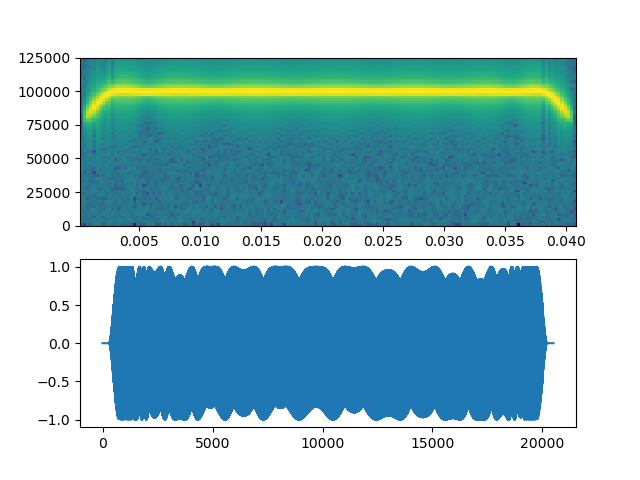

In [8]:
plt.figure()
plt.subplot(211)
plt.specgram(audio_w_noise,Fs=fs);
plt.ylim(0,125000)
plt.subplot(212)
plt.plot(audio_w_noise)

In [9]:
# design peak amplifier 
filter_size = 500
freqs = np.fft.rfftfreq(filter_size, 1/fs)
freqs[-1] = fs*0.5
freq_gain = np.ones(freqs.size)
freq_gain[np.argmin(abs(freqs-peak_frequency))] = 20 # amplify only the peak frequency
freq_gain[-1] = 0
peak_amp = signal.firwin2(filter_size, freqs, freq_gain, fs=fs)

<IPython.core.display.Javascript object>


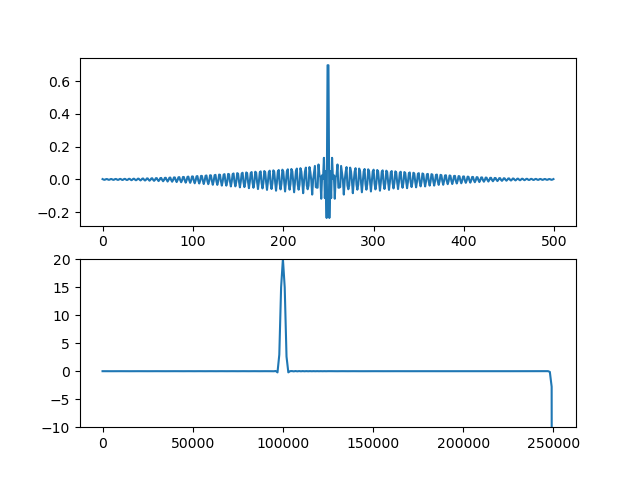

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-10, 20)

In [10]:
plt.figure()
plt.subplot(211)
plt.plot(peak_amp)
plt.subplot(212)
plt.plot(freqs, dB(np.fft.rfft(peak_amp)))
plt.ylim(-10,20)

In [11]:
# filter signal left an right to amplify peak frequency
zeropad_samples = 1000
peak_amp_zeropad = np.pad(audio_w_noise, pad_width=zeropad_samples,mode='constant', constant_values=0 )
peakamp_audio = signal.convolve(peak_amp_zeropad,peak_amp,'same')
peakamp_audio = peakamp_audio[zeropad_samples:-zeropad_samples]

In [12]:
dyn_range = [dB(np.max(abs(audio_w_noise)))-20, dB(np.max(abs(audio_w_noise)))- 90]

<IPython.core.display.Javascript object>


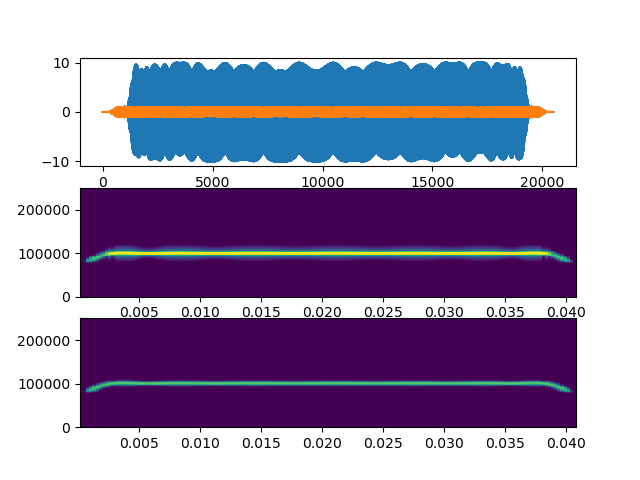

In [13]:
plt.figure()
plt.subplot(311)
plt.plot(peakamp_audio)
plt.plot(audio_w_noise)
plt.subplot(312)
plt.specgram(peakamp_audio, Fs=fs, vmax=dyn_range[0], vmin=dyn_range[1]);
plt.subplot(313)
plt.specgram(audio_w_noise, Fs=fs, vmax=dyn_range[0], vmin=dyn_range[1]);

<IPython.core.display.Javascript object>


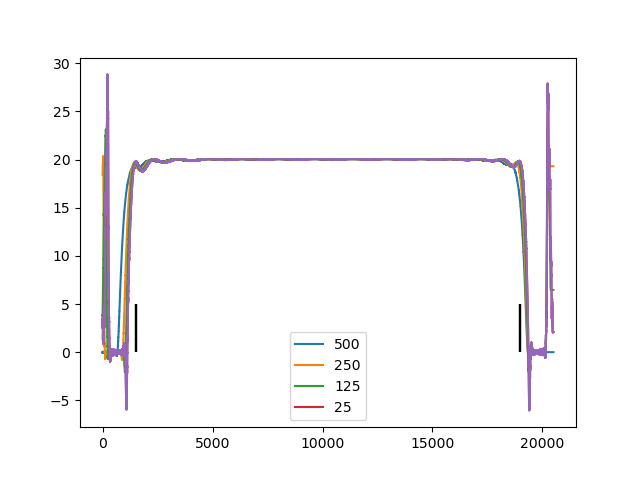

In [14]:
plt.figure()
for winsize in [500, 250, 125, 25]:
    cf_amped_energy  = moving_rms(peakamp_audio, window_size=winsize)
    cf_call_energy = moving_rms(audio_w_noise, window_size=winsize)
    diff_energy = cf_amped_energy/cf_call_energy
    plt.plot(dB(diff_energy), label=winsize)
    start, stop = calc_sound_borders(diff_energy, 85)
    plt.vlines([start, stop], 0, 5, zorder=10)
    #plt.hlines(np.max(dB_diffenergy)-10, 0,  dB_diffenergy.size)
plt.legend()

In [15]:
cf_amped_energy  = moving_rms(peakamp_audio, window_size=winsize)
cf_call_energy = moving_rms(audio_w_noise, window_size=winsize)
diff_energy = cf_amped_energy/cf_call_energy
plt.plot(dB(diff_energy), label=winsize)
start, stop = calc_sound_borders(diff_energy, 85)
plt.vlines([start, stop], 0, 5, zorder=10)
durn = (stop - start)/fs
print(np.round(durn,3))

0.035


In [16]:
import warnings

In [17]:
def amplify_frequency(audio, frequency, fs, **kwargs):
    '''
    '''
    # design peak amplifier 
    filter_size = kwargs.get('filter_size', int(fs*0.002))
    freqs = np.fft.rfftfreq(filter_size, 1/fs)
    freqs[-1] = fs*0.5
    freq_gain = np.ones(freqs.size)
    max_gain = kwargs.get('frequency_gain', 20)
    freq_gain[np.argmin(abs(freqs-frequency))] = max_gain # amplify only the peak frequency
    freq_gain[-1] = 0
    single_frequency_amplifier = signal.firwin2(filter_size, freqs, freq_gain, fs=fs)
    
    one_frequency_amplified = signal.convolve(audio, single_frequency_amplifier, 'same')
    return one_frequency_amplified, single_frequency_amplifier
    
def segment_CF(audio,fs,  **kwargs):
    '''Identifies and separates out the CF part of a call. 
    This function works on the premise that the peak frequency in the audio segment is the 
    constant frequency portion. The peak frequency in the call is amplified and a 
    relative rms profile is calculated to see which portion of the call is most amplified. 
    
    The part which is most amplified is the CF part, and this is used to identify its start
    and end portion. 

    Parameters
    ----------
    audio : np.array
    fs : float
    

    
    
    
    '''
  
    peak_frequency = get_peak_frequency(audio,fs)

    # filter out the FM parts with a strong highpass filter
    b,a = signal.ellip(4, 3 , 18, peak_frequency,'highpass', fs)
    cf_amplified = signal.lfilter(b,a, audio)
    rms_cfamplified = moving_rms(cf_amplified, **kwargs)

    #get region that was most amplified:
    cf_borders = identify_amplified_portion(rms_cfamplified, **kwargs)

    return audio_relative_rms, cf_borders

def calculate_relative_amp_profile(original, amplified, **kwargs):
    '''
    '''
    moving_rms_original = moving_rms(original, **kwargs)
    moving_rms_amplified = moving_rms(amplified, **kwargs)
    relative_amp_profile = moving_rms_amplified/moving_rms_original
    return relative_amp_profile

def identify_amplified_portion(relative_amp_profile, **kwargs):
    '''Calculates the region of the call that was most aplified. 
    Converts the linear amplification into dB and then calcualtes
    an amplification threshold. 


    
    Notes
    -------
    This method *assumes* a sound that is placed more or less in the centre of the selection. 

    The boundaries of the most amplified portion is calcualted so.
    1) Get the maximum observed amplification in dB. eg. if max amplification was 4X, then it would be 12dB
    2) Calculate a threshold below the maximum. Defaults to 6 dB below max. Here the threshold amplification
       would be 12-6 = 6dB
    3) Choose the start and end of the amplified porition by selecting the indices of values that 
       are <= threshold and are closest to the centre of the relative amp profile on the left and right.  
   
    '''
    dB_amp_profile = dB(relative_amp_profile)
    if np.max(dB_amp_profile)>=60:
        warnings.warn_explicit('There are regions amplified by over 1000times. This is unlikely and probably because of noise')
        
    
    max_amp_dB = np.max(dB_amp_profile)
        
    threshold = max_amp_dB - kwargs.get('dB_threshold', 6)
    samples_below_threshold = np.argwhere(dB_amp_profile.flatten() <= threshold).flatten()
    middle_point = int(relative_amp_profile.size*0.5)
    try:
        start_stop = closest_points_to_middle(samples_below_threshold, middle_point)
        return start_stop
    except:
        raise SegmentationError('There seems to be little variation in relative amplification. This could happen when there is only a CF porition in the whole selection \
        Try one of the follow: 1) reduce dB_threshold, 2) increase the time window to include background or FM portions')

    
    
def closest_points_to_middle(samples_below_threshold, middle):
    '''
    '''
    
    points_to_left = samples_below_threshold[samples_below_threshold < middle]
    points_to_right = samples_below_threshold[samples_below_threshold > middle]
    
    # choose start of region
    start, stop = np.max(points_to_left), np.min(points_to_right)
    
    return [start, stop]

def make_call_and_test_accuracy(**kwargs):
    '''
    '''
    cf_duration = kwargs.get('cf_duration', 0.045)
    fm_duration = kwargs.get('fm_duration', 0.005)
    call_duration = fm_duration + cf_duration
    cf_frequency = kwargs.get('cf_frequency', 100000)
    call_shape = kwargs.get('call_shape', 'staplepin')
    fs = kwargs.get('fs', 250000)
    fm_bandwidth = kwargs.get('fm_bandwidth', 15000)
    
    one_call = make_one_CFcall(call_duration, fm_duration, cf_frequency, fs,
                               call_shape, fm_bandwidth=fm_bandwidth)
    one_call *= signal.tukey(one_call.size, 0.1)
    
    # get call parameters
    actual = pd.DataFrame(data={'cf_duration':[cf_duration],
                                'fm_duration':[fm_duration],
                                'cf_frequency':[cf_frequency],
                                'fm_bandwidth':[fm_bandwidth]})
    
    
    return one_call, actual

class SegmentationError(ValueError):
    pass

In [18]:
fs = 250000*3

In [19]:
call, actual = make_call_and_test_accuracy(cf_duration=0.05, fm_duration=0.01, fm_bandwidth=500,
                                           fs=fs)
gap = int(0.001*fs)
call_w_noise = np.random.normal(0,10**-60/20,call.size+gap*2)
call_w_noise[gap:-gap] += call
fine_selection = calc_sound_borders(call_w_noise, 95)
narrow_audio = call_w_noise[fine_selection[0]:fine_selection[1]]

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:119: RankWarning: Polyfit may be poorly conditioned


### Upsample, and then elliptic filter

In [20]:
audio = call_w_noise.copy()
kwargs = {}
peak_frequency = get_peak_frequency(audio,fs)

# filter out the FM parts with a strong highpass filter
b,a = signal.ellip(4, 10, 18, peak_frequency,'highpass', fs=fs)
cf_amplified = signal.lfilter(b,a, audio)
rms_cfamplified = moving_rms(cf_amplified, **kwargs)
#get region that was most amplified:
cf_borders = identify_amplified_portion(rms_cfamplified, dB_threshold=2)
np.diff(cf_borders)/fs


array([0.04076933])

In [21]:
peak_frequency

100016.12903225806

In [22]:
# filter out the FM parts with a strong highpass filter
b,a = signal.iirnotch(100000.0/(fs*0.5), Q=5, fs=fs)
lp_amplified = signal.lfilter(b,a, audio)
rms_fmamplified = moving_rms(lp_amplified, **kwargs)


In [23]:
orig = get_power_spectrum(audio,fs=fs)
lp = get_power_spectrum(lp_amplified,fs=fs)

<IPython.core.display.Javascript object>


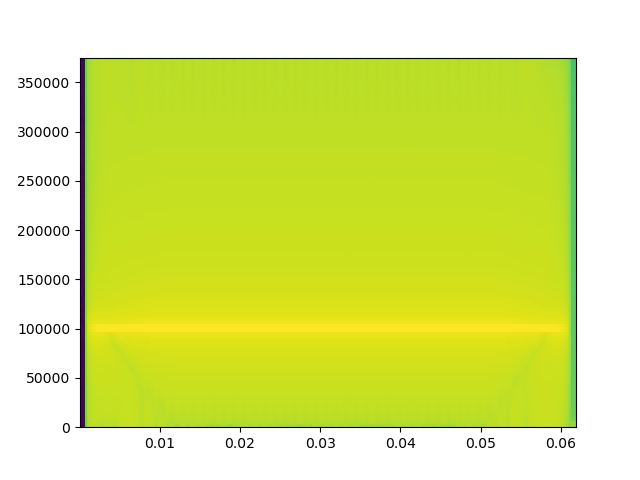

In [24]:
plt.figure()
plt.specgram(lp_amplified, Fs=fs);

<IPython.core.display.Javascript object>


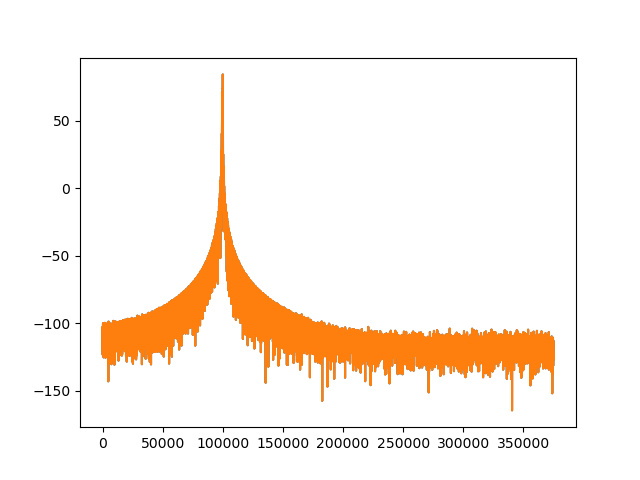

In [25]:
plt.figure()
plt.plot(orig[1], orig[0])
plt.plot(lp[1], lp[0])

<IPython.core.display.Javascript object>


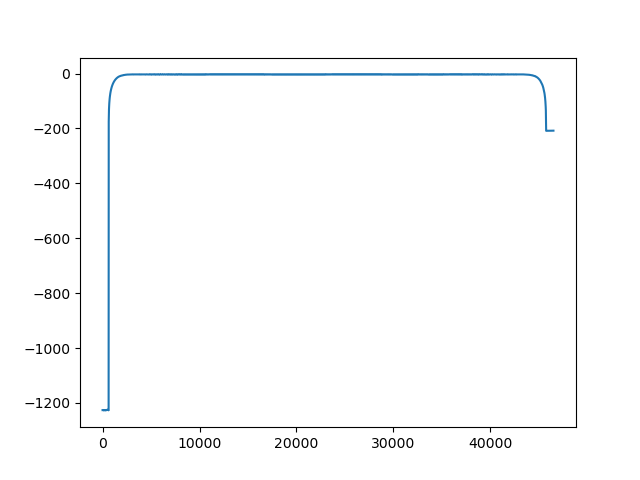

In [26]:
plt.figure()
#plt.plot(lp_amplified)
plt.plot(dB(rms_fmamplified))

<IPython.core.display.Javascript object>


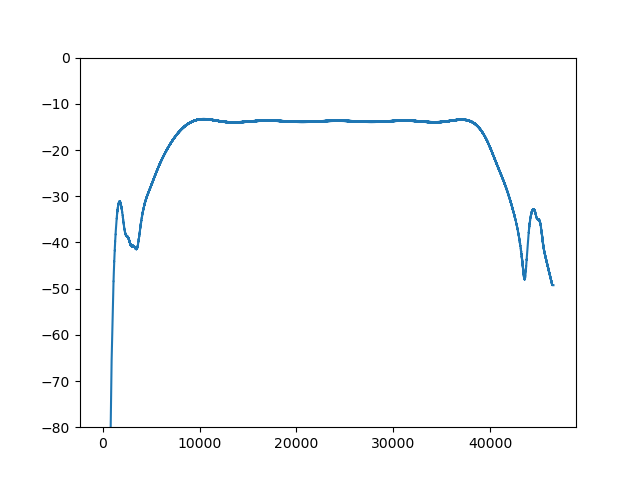

[0.04076933]


In [27]:
plt.figure()
#plt.plot(cf_amplified)
plt.plot(dB(rms_cfamplified))
plt.ylim(-80,0)
print(np.diff(cf_borders)/fs)

In [28]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [29]:
audio

array([ 6.58982202e-62, -3.37663277e-62, -3.37198963e-63, ...,
        2.47213701e-62, -7.66650547e-62,  6.52107813e-62])

In [30]:
wavelet = pywt.ContinuousWavelet('fbsp')
[coefs, freqs] = pywt.cwt(audio, np.arange(3,20), wavelet, 1.0/fs)
print(freqs)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  """Entry point for launching an IPython kernel.


[125000.          93750.          75000.          62500.
  53571.42857143  46875.          41666.66666667  37500.
  34090.90909091  31250.          28846.15384615  26785.71428571
  25000.          23437.5         22058.82352941  20833.33333333
  19736.84210526]


<IPython.core.display.Javascript object>


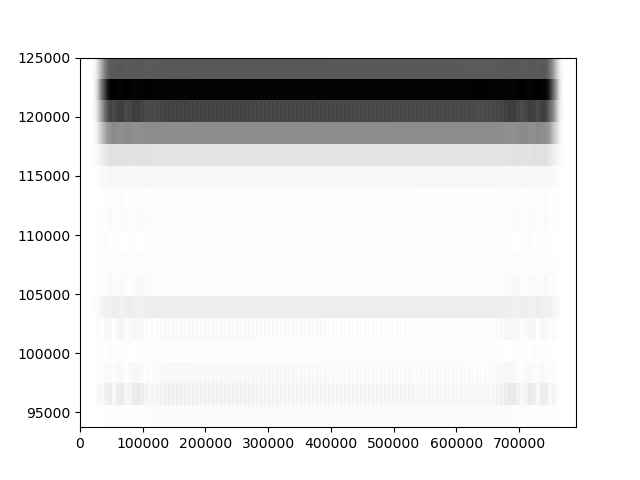

In [31]:
plt.figure()
plt.imshow(abs(coefs), aspect='auto', cmap='Greys', interpolation='none',
        extent=[0, coefs.size, freqs[1], freqs[0]])

In [32]:
abs(coefs[1,:])

array([2.34117998e-62, 2.37600723e-62, 2.80398552e-62, ...,
       3.22397816e-62, 2.28900302e-62, 1.14406175e-62])

<IPython.core.display.Javascript object>


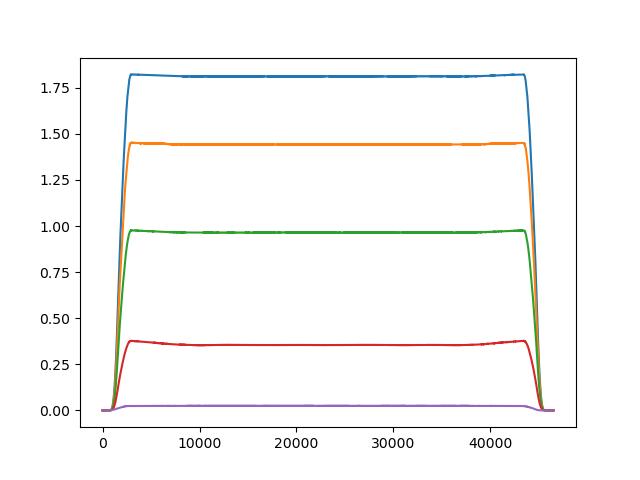

In [33]:
plt.figure()
plt.plot(moving_rms(abs(coefs[1,:])))
plt.plot(moving_rms(abs(coefs[2,:])))
plt.plot(moving_rms(abs(coefs[3,:])))
plt.plot(moving_rms(abs(coefs[4,:])))
plt.plot(moving_rms(abs(coefs[8,:])))

In [34]:
t = np.linspace(0,0.04,int(fs*0.04))
cf = np.sin(2*np.pi*100000*t)
cf *= signal.tukey(cf.size)

y  = np.pad(cf, (1000,1000), constant_values=0)

<IPython.core.display.Javascript object>


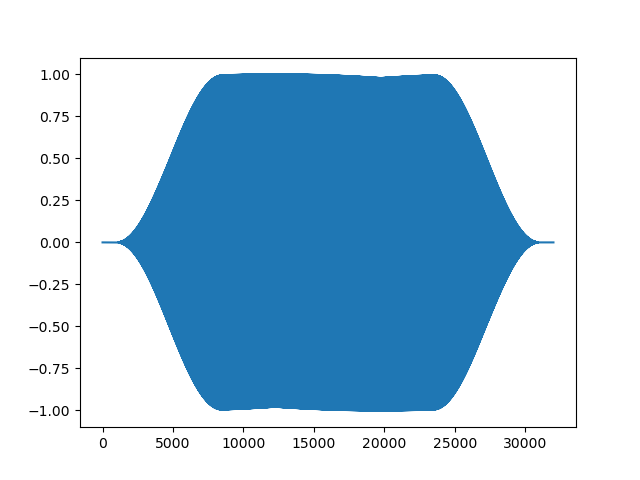

In [35]:
plt.figure()
plt.plot(y)

In [36]:
fs

750000

In [37]:
ycwt, freqs = pywt.cwt(y, np.arange(1,20), wavelet, 1.0/fs)
print(freqs)

[375000.         187500.         125000.          93750.
  75000.          62500.          53571.42857143  46875.
  41666.66666667  37500.          34090.90909091  31250.
  28846.15384615  26785.71428571  25000.          23437.5
  22058.82352941  20833.33333333  19736.84210526]


<IPython.core.display.Javascript object>


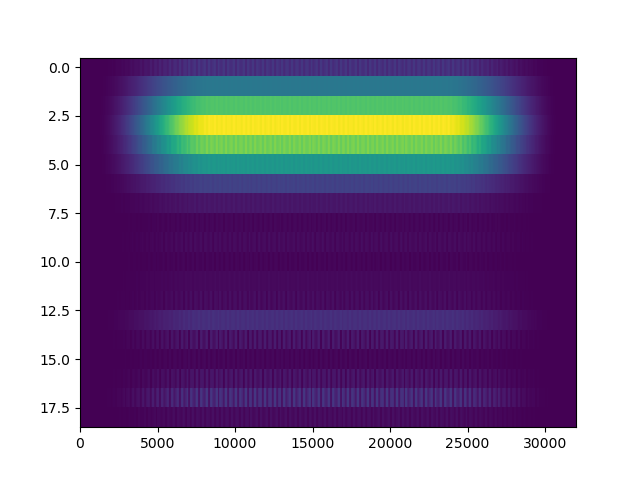

In [38]:
plt.figure()
plt.imshow(abs(ycwt), aspect='auto')

<IPython.core.display.Javascript object>


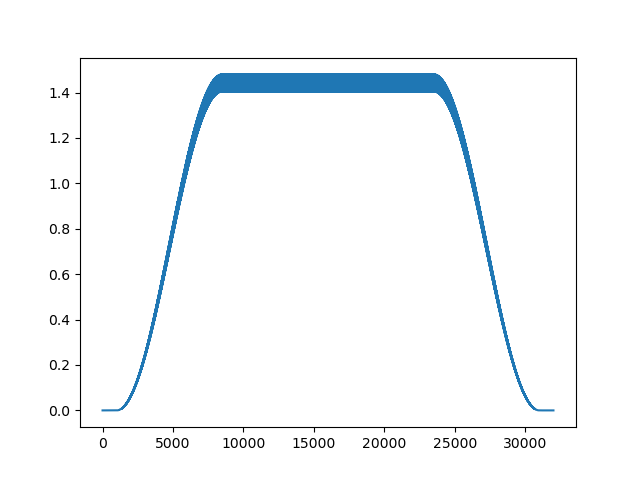

In [39]:
plt.figure()
plt.plot(abs(ycwt[4,:]))